# Exploration notebook - Best Model Pipeline

## Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

## Datasources

Datasources for this notebooks are preprocessed dataframe (output from build_project.py)

transformers.py module contain full preprocessing pipeline.

Multiple preprocessing methodes was run :
- undersampling
- SMOTE
- no preprocess balancing (for baseine and class_weight define on model-fit level hypothesis)

### Import dataset from balancing script output

In [3]:
# load train datasets 
# - unbalanced datasets
base_path = '../datasets/compute'
transform_df_train_split = pd.read_csv(f"{base_path}/transform_df_train_split.csv")
transform_df_train_split_target = pd.read_csv(f"{base_path}/transform_df_train_split_target.csv")

# - undersampled datasets
undersample_df_train_split = pd.read_csv(f"{base_path}/undersample_df_train_split.csv")
undersample_df_train_split_target = pd.read_csv(f"{base_path}/undersample_df_train_split_target.csv")

# - oversample datasets
oversample_df_train_split = pd.read_csv(f"{base_path}/overersample_df_train_split.csv")  ## TODO : /!\ erreur nommenclature dans le nom du fichier a modifier...
oversample_df_train_split_target = pd.read_csv(f"{base_path}/oversample_df_train_split_target.csv")

In [4]:
# load eval datasets

transform_df_eval_split = pd.read_csv(f"{base_path}/transform_df_eval_split.csv")
transform_df_eval_split_target = pd.read_csv(f"{base_path}/transform_df_eval_split_target.csv")


### Check target balance for each split

Objectif : vérifier l'intégrité des datasets chargés pour l'études
- nombre de colones identiques d'un jeu de données a l'autre
- équilibre entre classes pour les jeux de données undersample et oversample
- déséquilibre entre classes pour les jeux de données 'transform_train' et eval
- conhérence des volumes de données pour chaque jeu de données

transform_df_train_split target balance: shape(246008, 127)


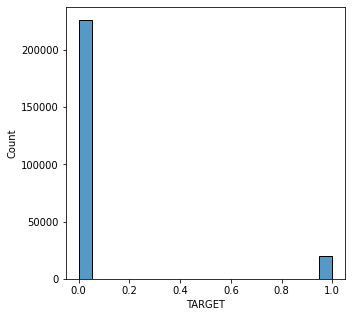

In [5]:
print(f"transform_df_train_split target balance: shape{transform_df_train_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=transform_df_train_split_target, x="TARGET")
plt.show()

undersample_df_train_split target balance: shape(39720, 127)


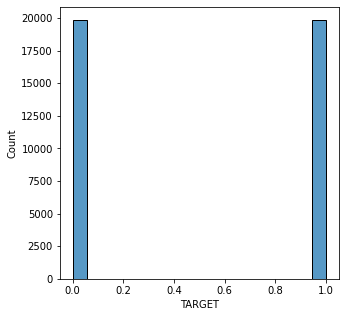

In [6]:
print(f"undersample_df_train_split target balance: shape{undersample_df_train_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=undersample_df_train_split_target, x="TARGET")
plt.show()

oversample_df_train_split target balance: shape(452296, 127)


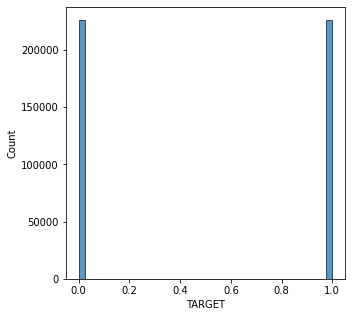

In [7]:
print(f"oversample_df_train_split target balance: shape{oversample_df_train_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=oversample_df_train_split_target, x="TARGET")
plt.show()

transform_df_eval_split target balance: shape(61503, 127)


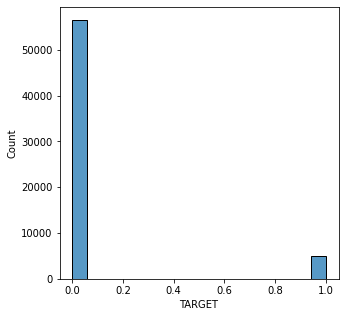

In [8]:
print(f"transform_df_eval_split target balance: shape{transform_df_eval_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=transform_df_eval_split_target, x="TARGET")
plt.show()

## Best Balancing method ?

Objectif : identifier la méthode de balancing conférent les meilleurs résultats pour un modéle donnée
- modéle de référence == lgbm  (meilleur modéle a priori d'aprés la communauté kaggle pour ce jeu de donnée)
- Pas de GridSearchCV pour cette étape exploratoire -> configuration sur les params par default

In [9]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
      an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    print("Detail:")
    print(metrics.classification_report(y_true, y_pred))
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    
    roc_auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.subplot(222)
    fpr,tpr,_ = metrics.roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        #plt.subplot(212)
        xgb.plot_importance(model.named_steps['classifier'], max_num_features=20, height=0.2)
        plt.xticks(rotation=90)

    plt.show()

In [28]:
lgbm_params_base = params = {
    'objective':'binary',
    'n_jobs': 4
}



Processing unbalanced hypothesis ... 
(246008, 127)
(246008, 1)
fitting model...
evaluating model ...
   score : 0.9195323805342829
   recall : 0.020342396777442096
   precision : 0.543010752688172
   fbeta_2 : 0.025192058265988224
   roc_auc : 0.7521779058524818
Detail:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.54      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



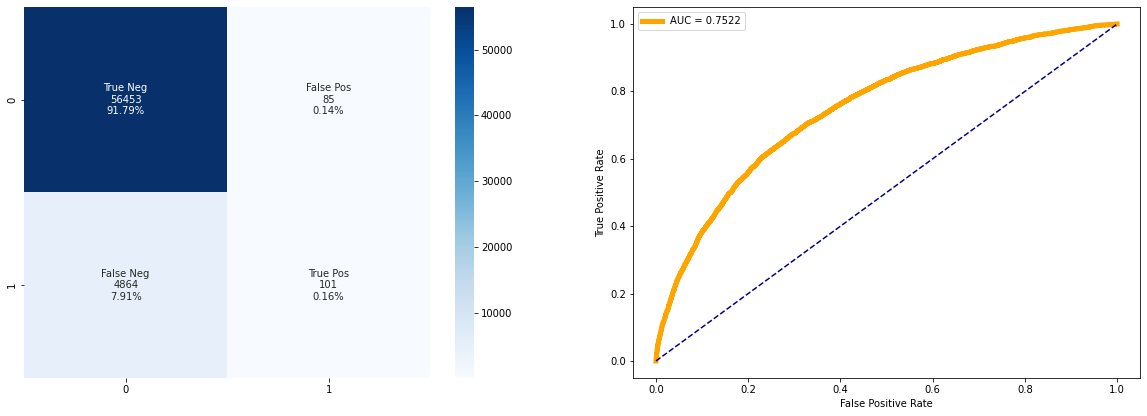


Processing class_weight hypothesis ... 
(246008, 127)
(246008, 1)
class_weight ratio : 11.38710976837865
fitting model...
evaluating model ...
   score : 0.7073476090597207
   recall : 0.6656596173212488
   precision : 0.16824475666870292
   fbeta_2 : 0.4183120696638315
   roc_auc : 0.7527417060033628
Detail:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.67      0.27      4965

    accuracy                           0.71     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.71      0.77     61503



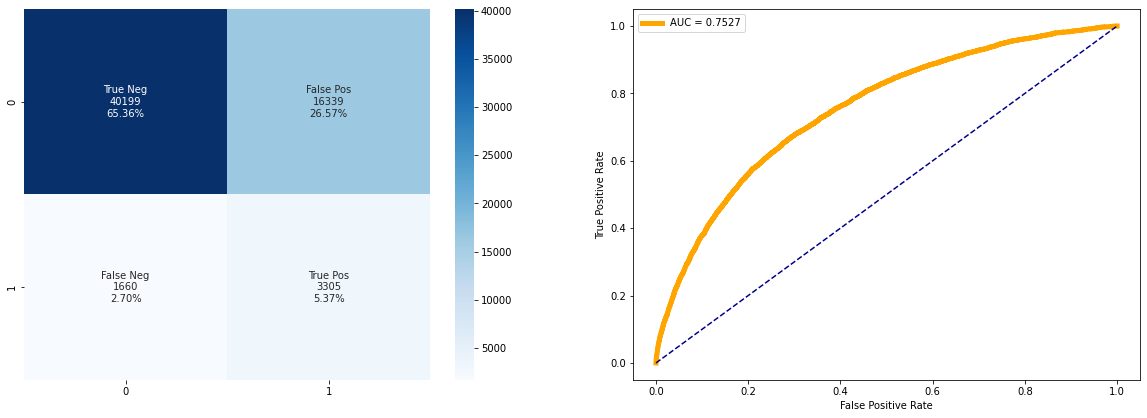


Processing undersampled hypothesis ... 
(39720, 127)
(39720, 1)
fitting model...
evaluating model ...
   score : 0.6933157732143147
   recall : 0.678147029204431
   precision : 0.1632010081915564
   fbeta_2 : 0.41577140599145485
   roc_auc : 0.7507738291996005
Detail:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



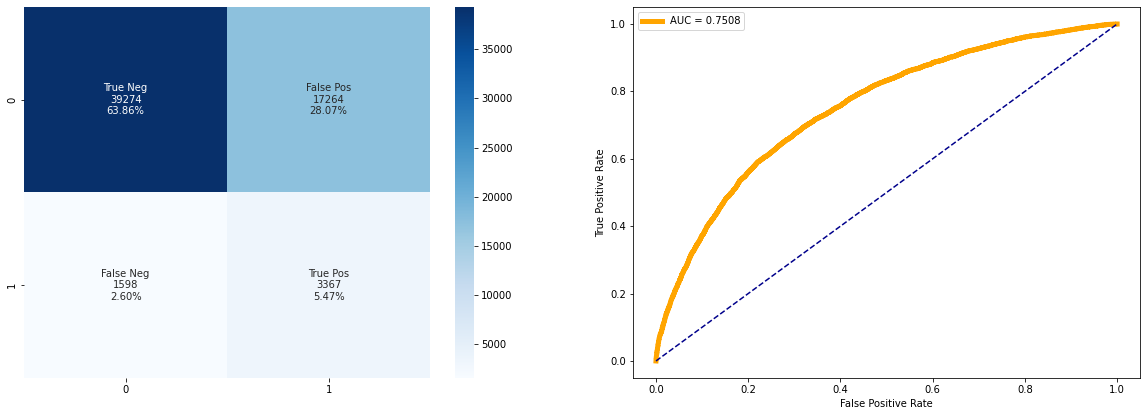


Processing oversapmled hypothesis ... 
(452296, 127)
(452296, 1)
fitting model...
evaluating model ...
   score : 0.9190933775588183
   recall : 0.013293051359516616
   precision : 0.46153846153846156
   fbeta_2 : 0.01649752537119432
   roc_auc : 0.7488805700179298
Detail:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.46      0.01      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.69      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



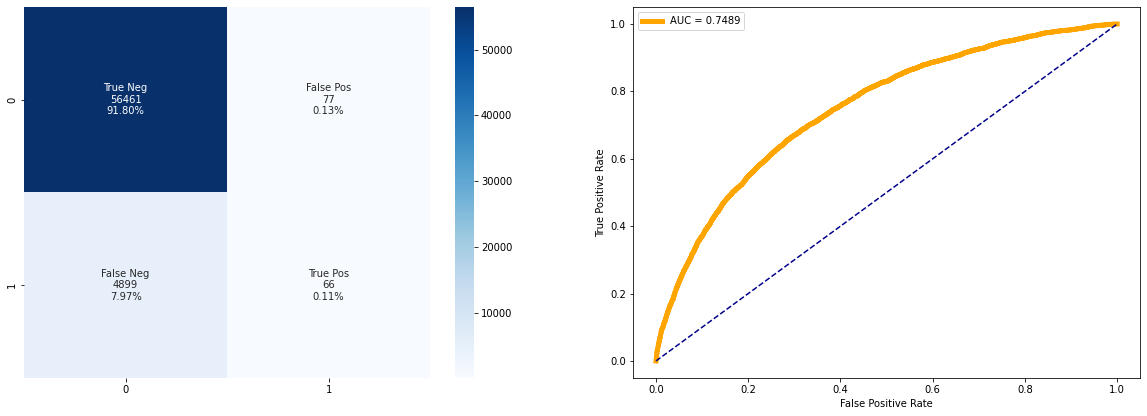

In [29]:
hypothesis_dfs = {
    'unbalanced' : (transform_df_train_split, transform_df_train_split_target),
    'class_weight': (transform_df_train_split, transform_df_train_split_target),
    'undersampled': (undersample_df_train_split, undersample_df_train_split_target),
    'oversapmled': (oversample_df_train_split, oversample_df_train_split_target)
    
}

hypothesis_scores = {}

for key, values in hypothesis_dfs.items():
    print(f"\nProcessing {key} hypothesis ... ")
    print(values[0].shape)
    print(values[1].shape)
    
    if key != 'class_weight':
        classifier = lgb.LGBMClassifier(**lgbm_params_base)
    else:
        count_class_1 = values[1].value_counts()[0]
        count_class_2 = values[1].value_counts()[1]
        ratio = count_class_1 / count_class_2
        print(f"class_weight ratio : {ratio}")
        classifier = lgb.LGBMClassifier(class_weight={1:ratio, 0:1}, **lgbm_params_base)
        
    print("fitting model...")
    classifier.fit(values[0], values[1])
    
    print("evaluating model ...")
    predicted = classifier.predict(transform_df_eval_split)
    predicted_proba = classifier.predict_proba(transform_df_eval_split)
    
    score = classifier.score(transform_df_eval_split, transform_df_eval_split_target)
    recall = metrics.recall_score(transform_df_eval_split_target, predicted)
    precision = metrics.precision_score(transform_df_eval_split_target, predicted)
    fbeta_2 = metrics.fbeta_score(transform_df_eval_split_target, predicted, beta=2)
    roc_auc = metrics.roc_auc_score(transform_df_eval_split_target, predicted_proba[:,1])
    
    
    hypothesis_scores[key] = {
        'score' : score,
        'recall' : recall,
        'precision' : precision,
        'fbeta_2' : fbeta_2,
        'roc_auc' : roc_auc
    }
    for k, v in hypothesis_scores[key].items():
        print(f"   {k} : {v}")
    
    cf_matrix_roc_auc(classifier, transform_df_eval_split_target, predicted, predicted_proba[:,1], feature_importances=False)

In [34]:
hypothesis_scores_df = pd.DataFrame(hypothesis_scores).T
hypothesis_scores_df = hypothesis_scores_df.reset_index()

hypothesis_scores_df



,index,score,recall,precision,fbeta_2,roc_auc
0,unbalanced,0.919532,0.020342,0.543011,0.025192,0.752178
1,class_weight,0.707348,0.665660,0.168245,0.418312,0.752742
2,undersampled,0.693316,0.678147,0.163201,0.415771,0.750774
3,oversapmled,0.919093,0.013293,0.461538,0.016498,0.748881


In [40]:
formated_h_scores = pd.melt(hypothesis_scores_df, id_vars=['index'], value_vars=['fbeta_2', 'roc_auc'])
formated_h_scores.head(10)

,index,variable,value
0,unbalanced,fbeta_2,0.025192
1,class_weight,fbeta_2,0.418312
2,undersampled,fbeta_2,0.415771
3,oversapmled,fbeta_2,0.016498
4,unbalanced,roc_auc,0.752178
5,class_weight,roc_auc,0.752742
6,undersampled,roc_auc,0.750774
7,oversapmled,roc_auc,0.748881


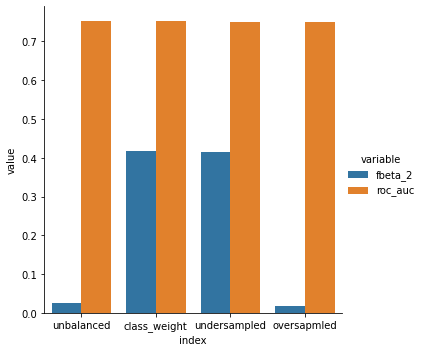

In [45]:
## plot bargraph for scores
ax = sns.factorplot(x='index', y='value', hue='variable', data=formated_h_scores, kind='bar')


## Scoring function

objectif : Définir une fonction score adapté a notre problématique pour l'entrainement des modèles

In [ ]:
fbeta_scorer = metrics.make_scorer(metrics.fbeta_score, greater_is_better=True, beta=2)

## Best Model ?

Objectif : Identifier le meilleur modéle possible sur notre jeu de données
- comparaison de différents type de modéle
- optmisation des paramétres par GridsearchCV